                     Accuracy  Macro Avg F1  Weighted Avg F1
Logistic Regression  0.731452      0.520947         0.707004
Random Forest        0.927900      0.896009         0.926991
XGBoost              0.710554      0.516735         0.692245


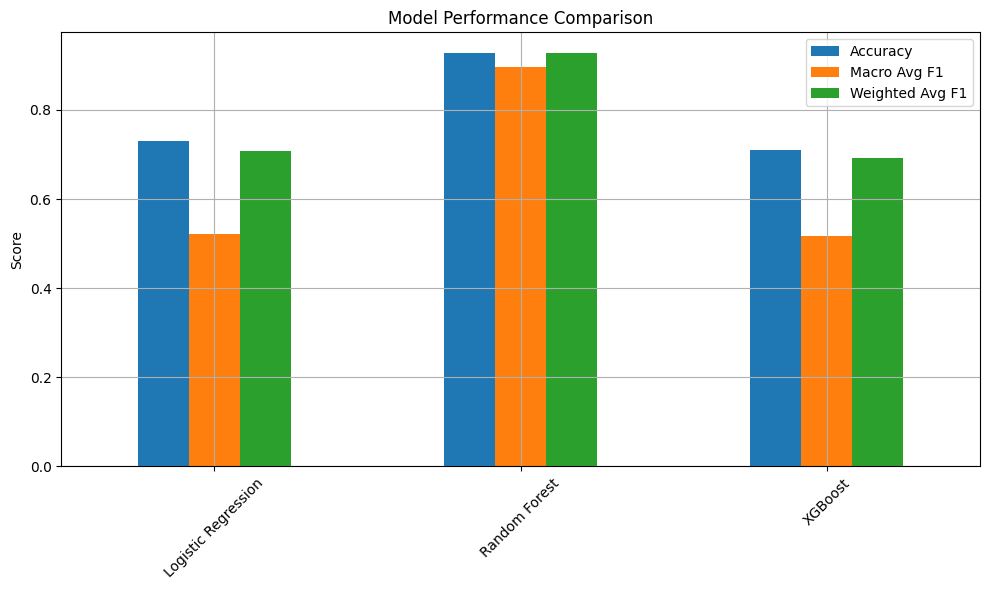

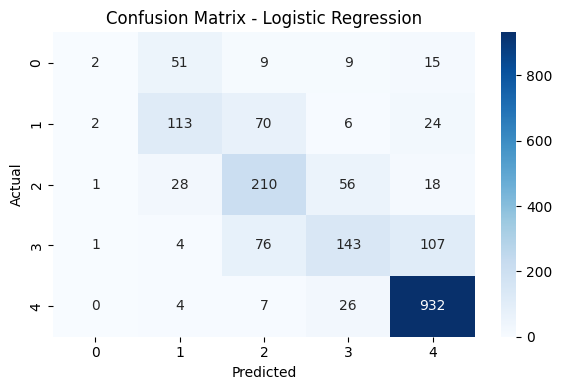

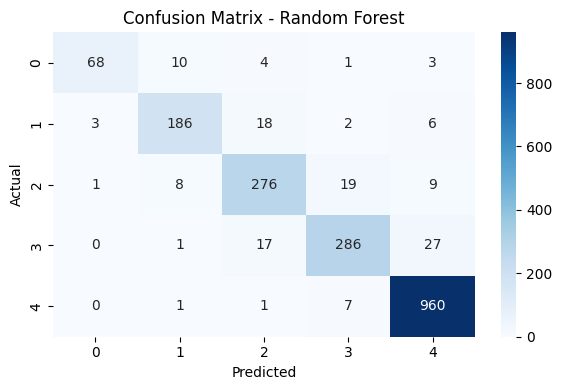

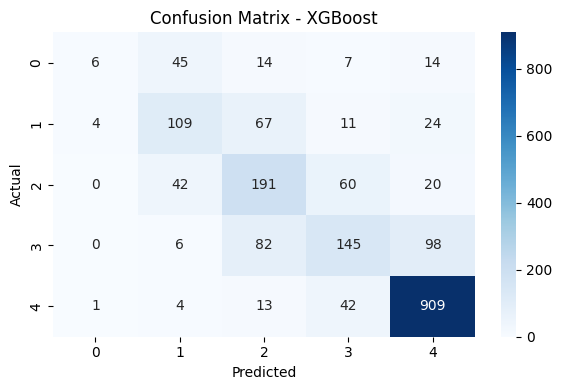

In [ ]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

#Import model to improve accuracy of logreg model
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

def tune_model(model_name, X_train, y_train):
    if model_name == 'logreg':
        model = LogisticRegression()
        param_grid = {
            'C': [0.01, 0.1, 1, 10],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear']  # only solver supporting both l1/l2
        }
    elif model_name == 'rf':
        model = RandomForestClassifier()
        param_grid = {
            'n_estimators': [100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5]
        }
    elif model_name == 'xgb':
        model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
        param_grid = {
            'n_estimators': [100, 200],
            'max_depth': [3, 6, 10],
            'learning_rate': [0.01, 0.1, 0.2]
        }
    else:
        raise ValueError("Unsupported model name. Choose from 'logreg', 'rf', or 'xgb'.")

    grid = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)

    print(f"Best parameters for {model_name}: {grid.best_params_}")
    return grid.best_estimator_

#Step 1: Load the test dataset
df = pd.read_csv('../data/Student_performance_data.csv')

X = df.drop(columns=["StudentID", "GradeClass", "GPA"])
y = df["GradeClass"]

#Ensure reproducibility and stratified split
_, X_test, _, y_test = train_test_split(X, y, test_size=0.8, random_state=50, stratify=y)

#Step 2: Define model and optional scaler paths
model_paths = {
    'Logistic Regression': {
        'model': '../artifacts/regression_model.pkl',
        'scaler': '../artifacts/regression_scaler.pkl'
    },
    'Random Forest': {
        'model': '../artifacts/randomforest_model.pkl',
        'scaler': None
    },
    'XGBoost': {
        'model': '../artifacts/xgboost_model.pkl',
        'scaler': None
    }
}

#Step 3: Load models and optional scalers
trained_models = {}
scalers = {}

for name, paths in model_paths.items():
    with open(paths['model'], 'rb') as f:
        trained_models[name] = pickle.load(f)
    
    if paths['scaler']:
        with open(paths['scaler'], 'rb') as f:
            scalers[name] = pickle.load(f)

#Step 4: Evaluate each model
results = {}

for name, model in trained_models.items():
    # Apply scaler if it exists
    if name in scalers:
        X_test_input = scalers[name].transform(X_test)
    else:
        X_test_input = X_test
    
    y_pred = model.predict(X_test_input)
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    results[name] = {
        'Accuracy': acc,
        'Macro Avg F1': report['macro avg']['f1-score'],
        'Weighted Avg F1': report['weighted avg']['f1-score']
    }

#Step 5: Display results
comparison_df = pd.DataFrame(results).T
print(comparison_df)

comparison_df.plot(kind='bar', figsize=(10, 6))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

from sklearn.metrics import confusion_matrix
import seaborn as sns

for name, model in trained_models.items():
    X_input = scalers[name].transform(X_test) if name in scalers else X_test
    y_pred = model.predict(X_input)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()
